In [46]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import scipy
from sklearn import mixture
from utils import *
from vanderpol import Controlled_Vanderpole


device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(40)
mu = 1
dt = 0.1


N_data = int(1e5)


N_clusters_x_axis = np.array([9,9])
x_dim = N_clusters_x_axis.shape[0]
x_range = np.array([[-3.0,3.0],[-6.0,6.0]])


N_clusters_u_axis = np.array([9])
u_dim = N_clusters_u_axis.shape[0]
u_range = np.array([[-5.0,5.0]])

ctrl_coeff = 0.5

model = Controlled_Vanderpole(mu,x_range,u_range)

plt.style.use('dark_background')

In [47]:
DX1 = np.random.uniform(x_range[:,0],x_range[:,1],(N_data,x_dim))
DU1 = np.random.uniform(u_range[:,0],u_range[:,1],(N_data,u_dim))
DX2 = model.step(DX1,DU1)


gm = mixture.GaussianMixture(n_components=np.prod(N_clusters_x_axis))
mixture.GaussianMixture.cal_expect = lambda self,z: np.einsum('...n,nd->...d',z,self.means_,optimize='optimal')
x_lin = []
for i in range(N_clusters_x_axis.shape[0]):
    x_lin.append(np.linspace(x_range[i][0] , x_range[i][1], N_clusters_x_axis[i]))

x_centroids = cartesian_product_simple_transpose(x_lin)
x_cov = np.diag([(x_range[i,1]-x_range[i,0])**2/(12*N_clusters_x_axis[i]) for i in range(x_range.shape[0])])
x_cov = np.repeat(x_cov[None,:],x_centroids.shape[0],axis=0)
x_prio = np.ones((x_centroids.shape[0],))/x_centroids.shape[0]

gm.means_ = x_centroids
gm.covariances_ = x_cov
gm.weights_ = x_prio
gm.precisions_cholesky_ = mixture._gaussian_mixture._compute_precision_cholesky(gm.covariances_,gm.covariance_type)


# gm.cal_expect = 

# gm.fit(DX1)

PX1_1 = gm.predict_proba(DX1)
PX1_2 = gm.predict_proba(DX2)
koopman_model1 = pinv_Koopman(PX1_1,DU1,PX1_2)


/tmp/ipykernel_52297/1446570738.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(gm.means_[:,0],gm.means_[:,1],c=[0.5,0.5,0.1],label='centroids from clustering')


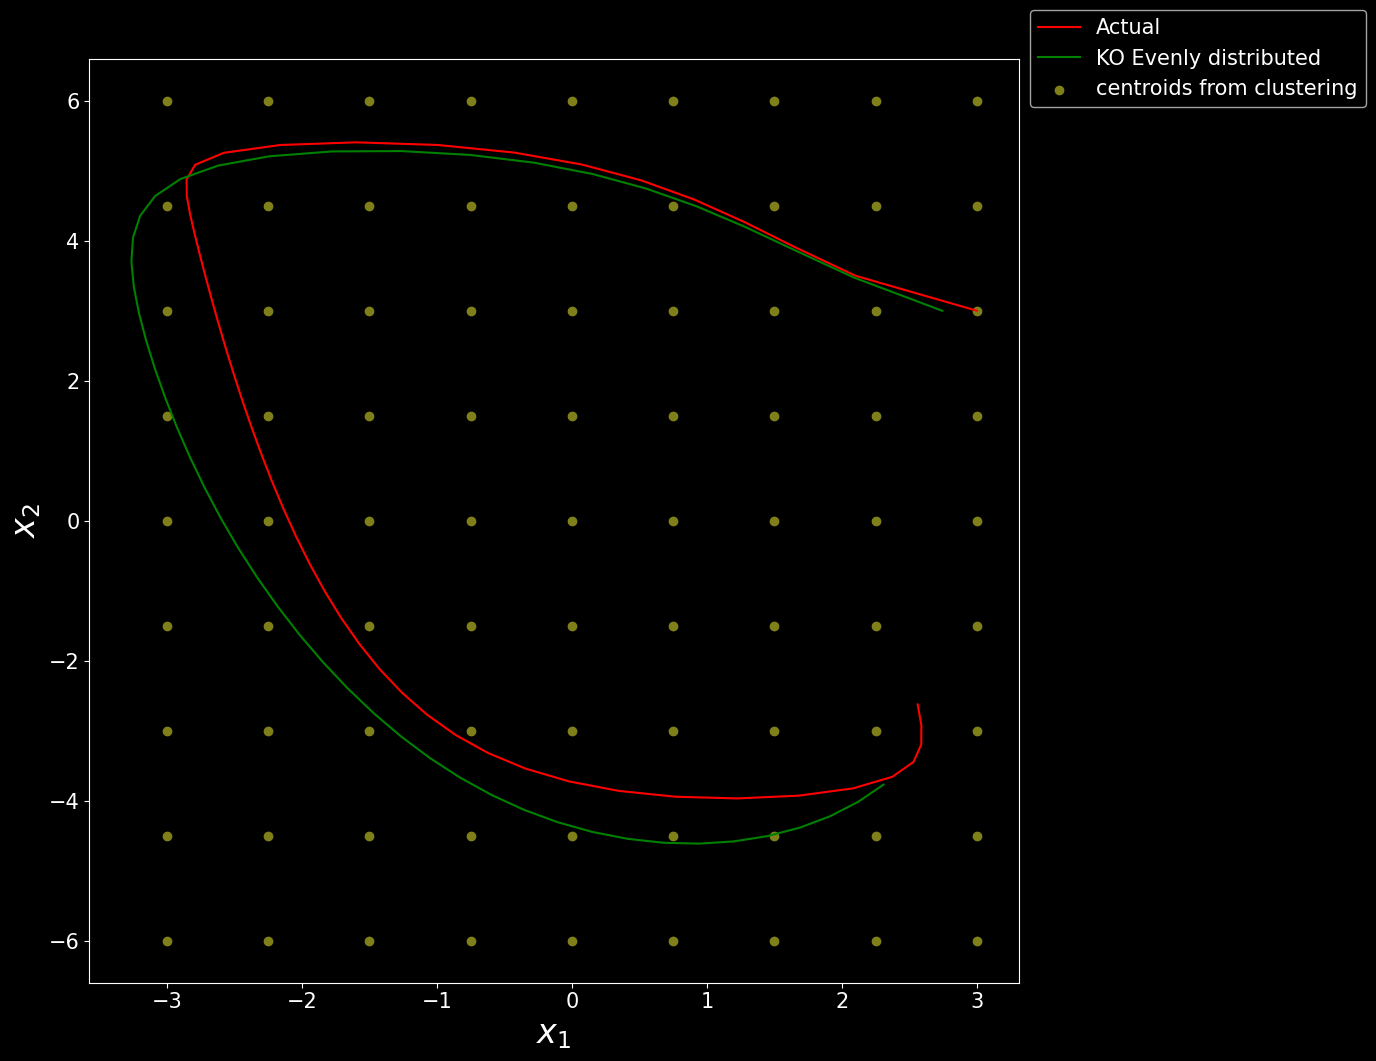

In [54]:
x = np.array([3.0,3.0])
N = 50

u = 2*np.cos(np.linspace(0,dt*N,N)).reshape(-1,1) #np.random.uniform(low=u_range[0,0],high=u_range[0,1],size=(N,1))
# u = np.zeros((N,1))
z1 = gm.predict_proba(x.reshape(1,-1)).squeeze()
x_his = np.zeros([N,2])
m_his1 = np.zeros([N,2])


for i in range(N):
    x_his[i] = x
    m_his1[i] =gm.cal_expect(z1)
    z1 = linear_step(koopman_model1,z1,u[i])
    x = model.step(x,u[i])
    
plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 15})

plt.plot(x_his[:,0],x_his[:,1],label = 'Actual',c='red')
plt.plot(m_his1[:,0],m_his1[:,1],label = 'KO Evenly distributed',c='green')


plt.xlabel('$x_1$',fontsize=24)
plt.ylabel('$x_2$',fontsize=24)
plt.scatter(gm.means_[:,0],gm.means_[:,1],c=[0.5,0.5,0.1],label='centroids from clustering')
plt.legend(loc='center left', bbox_to_anchor=(1, 1))